# Face Recognition with Live Webcam

## Session 7c: Real-Time Face Recognition Using Webcam (Local Jupyter)

This notebook loads your trained model and uses it to recognize faces in real-time from your webcam.

**Features**:
- **Live webcam feed** with real-time face recognition
- **Interactive controls** (start, preview, capture, stop)
- **Visual feedback** with predictions and confidence scores
- **Works in local Jupyter notebooks** (not Google Colab)

**Prerequisites**:
- Complete `07a_complete_face_recognition_pipeline.ipynb` first
- Have a trained model saved locally
- Model file: `face_model_YYYYMMDD_HHMMSS.h5`
- Class mappings file: `class_mapping_YYYYMMDD_HHMMSS.json`
- Webcam connected to your computer
- Local Jupyter notebook environment (not Colab)

**Note**: This notebook is designed for **local Jupyter notebooks**. For file upload in Google Colab, use `07b_face_recognition_colab.ipynb` instead.



## 0. Environment Setup (Important!)

### Why Use a Virtual Environment?

Using a virtual environment is **strongly recommended** for this project because:
- **Isolates dependencies**: Prevents conflicts with other Python projects
- **Version control**: Ensures consistent package versions
- **Clean installation**: Keeps your system Python clean
- **Reproducibility**: Others can recreate the same environment

### Setup Instructions

**⚠️ IMPORTANT: Activate the virtual environment BEFORE launching Jupyter!**

**Option 1: Using venv (Python 3.3+)**

```bash
# 1. Create virtual environment
python3 -m venv face_recognition_env

# 2. Activate virtual environment (DO THIS FIRST!)
# On macOS/Linux:
source face_recognition_env/bin/activate
# On Windows:
# face_recognition_env\Scripts\activate

# 3. Install required packages
pip install tensorflow opencv-python pillow ipywidgets matplotlib numpy jupyter

# 4. Launch Jupyter FROM THE ACTIVATED TERMINAL
jupyter notebook
```

**Option 2: Using conda (if you have Anaconda/Miniconda)**

```bash
# 1. Create conda environment
conda create -n face_recognition python=3.9

# 2. Activate environment (DO THIS FIRST!)
conda activate face_recognition

# 3. Install packages
pip install tensorflow opencv-python pillow ipywidgets matplotlib numpy jupyter
# OR use conda:
# conda install tensorflow opencv pillow ipywidgets matplotlib numpy jupyter

# 4. Launch Jupyter FROM THE ACTIVATED TERMINAL
jupyter notebook
```

### Verify Installation

After activating your environment, verify packages are installed:
```bash
python -c "import tensorflow as tf; print(f'TensorFlow: {tf.__version__}')"
python -c "import cv2; print(f'OpenCV: {cv2.__version__}')"
python -c "import jupyter; print('Jupyter installed')"
```

### Why Activate Before Launching Jupyter?

When you activate a virtual environment and then launch Jupyter from that terminal, Jupyter automatically uses the virtual environment's Python kernel. This ensures:
- All imports use packages from the venv
- No conflicts with system packages
- Consistent behavior across runs

**Note**: If you skip the virtual environment setup, you can install packages globally, but this is not recommended for production use.

---



## 1. Setup and Imports

Import all necessary libraries for face recognition with webcam.



In [1]:
# Install required packages if needed (uncomment if needed)
!pip install tensorflow opencv-python pillow ipywidgets

import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
from IPython.display import display, clear_output
import ipywidgets as widgets
import threading
import time
import csv
from datetime import datetime

# TensorFlow/Keras for model loading
import tensorflow as tf
from tensorflow import keras

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")



✅ All libraries imported successfully!
TensorFlow version: 2.20.0
OpenCV version: 4.12.0


## 2. Set Paths and Load Model

Configure paths to your saved model and load it along with class mappings.

**Note**: Update `MODELS_DIR` to point to where your trained model is saved.



In [2]:
# Set the path to your models directory
# Update this path to where your trained model is saved
MODELS_DIR = "./models"  # Change this to your model directory path

# Alternative: If you trained in Colab and downloaded the model
# MODELS_DIR = "/D:/AI/models"

print(f"Models directory: {MODELS_DIR}")

# Find the most recent model file
if os.path.exists(MODELS_DIR):
    model_files = [f for f in os.listdir(MODELS_DIR) if f.startswith('face_model_') and f.endswith('.h5')]
    mapping_files = [f for f in os.listdir(MODELS_DIR) if f.startswith('class_mapping_') and f.endswith('.json')]
    
    if model_files:
        # Sort by timestamp (filename contains timestamp)
        model_files.sort(reverse=True)
        mapping_files.sort(reverse=True)
        
        model_filename = model_files[0]
        mapping_filename = mapping_files[0] if mapping_files else None
        
        model_path = os.path.join(MODELS_DIR, model_filename)
        mapping_path = os.path.join(MODELS_DIR, mapping_filename) if mapping_filename else None
        
        print(f"\n✅ Found model: {model_filename}")
        if mapping_filename:
            print(f"✅ Found class mappings: {mapping_filename}")
        
        # Load the model
        print("\n🔄 Loading model...")
        # Try loading with compile=False first (helps with version compatibility)
        try:
            model = keras.models.load_model(model_path, compile=False)
        except Exception as e:
            # If that fails, try with safe_mode=False for newer Keras versions
            try:
                model = keras.models.load_model(model_path, compile=False, safe_mode=False)
            except Exception as e2:
                print(f"❌ Error loading model: {e2}")
                print("\n💡 This error often occurs due to TensorFlow/Keras version mismatch.")
                print("   Solution: Re-save the model in 07a notebook with:")
                print("   model.save(model_path, save_format='h5')")
                raise
        print("✅ Model loaded successfully!")
        
        # Load class mappings
        if mapping_path and os.path.exists(mapping_path):
            with open(mapping_path, 'r') as f:
                class_mapping = json.load(f)
            
            class_indices = class_mapping['class_indices']
            class_names = class_mapping['class_names']
            num_classes = class_mapping['num_classes']
            
            print(f"✅ Class mappings loaded!")
            print(f"📁 Classes: {class_names}")
            print(f"📊 Number of classes: {num_classes}")
        else:
            print("⚠️  Warning: Class mapping file not found")
            print("   You may need to manually set class_names")
            class_names = None
            class_indices = None
    else:
        print(f"\n❌ No model files found in {MODELS_DIR}")
        print("   Please run 07a_complete_face_recognition_pipeline.ipynb first to train a model")
        model = None
        class_names = None
        class_indices = None
else:
    print(f"\n❌ Models directory not found: {MODELS_DIR}")
    print("   Please check your paths and ensure you've trained a model")
    model = None
    class_names = None
    class_indices = None



Models directory: ./models

✅ Found model: face_model_20251202_035305.h5
✅ Found class mappings: class_mapping_20251202_035305.json

🔄 Loading model...
❌ Error loading model: Layer "dense" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, ragged=False, name=keras_tensor_644>, <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, ragged=False, name=keras_tensor_645>]

💡 This error often occurs due to TensorFlow/Keras version mismatch.
   Solution: Re-save the model in 07a notebook with:
   model.save(model_path, save_format='h5')


ValueError: Layer "dense" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, ragged=False, name=keras_tensor_644>, <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, ragged=False, name=keras_tensor_645>]

## 2b. Alternative Model Loading (If Section 2 Failed)

**⚠️ Use this section if you got an error in Section 2!**

If you encountered the error: `Layer "dense" expects 1 input(s), but it received 2 input tensors`, this is a known issue with TensorFlow/Keras version mismatches. The cell below will rebuild the model architecture and load the weights, which should work around this issue.

**How to use:**
1. Make sure Section 2 ran (even if it failed) - it should have loaded the class mappings
2. Run the cell below - it will rebuild the model and load weights
3. If this still fails, you'll need to re-save your model (see instructions in the error message)


In [3]:
# IMPROVED MODEL LOADING - Use this cell if Section 2 failed
# This version includes a workaround to rebuild the model architecture if loading fails

# First, ensure we have the class mappings loaded
if 'mapping_path' not in locals() or 'class_names' not in locals():
    # Try to find and load class mappings
    MODELS_DIR = "./models"
    if os.path.exists(MODELS_DIR):
        mapping_files = [f for f in os.listdir(MODELS_DIR) if f.startswith('class_mapping_') and f.endswith('.json')]
        if mapping_files:
            mapping_files.sort(reverse=True)
            mapping_path = os.path.join(MODELS_DIR, mapping_files[0])
            with open(mapping_path, 'r') as f:
                class_mapping = json.load(f)
            class_indices = class_mapping['class_indices']
            class_names = class_mapping['class_names']
            num_classes = class_mapping['num_classes']
            print(f"✅ Loaded class mappings: {len(class_names)} classes")
        else:
            print("❌ Could not find class mapping file")
            raise FileNotFoundError("Class mapping file not found")

# Ensure we have model_path
if 'model_path' not in locals():
    MODELS_DIR = "./models"
    if os.path.exists(MODELS_DIR):
        model_files = [f for f in os.listdir(MODELS_DIR) if f.startswith('face_model_') and f.endswith('.h5')]
        if model_files:
            model_files.sort(reverse=True)
            model_path = os.path.join(MODELS_DIR, model_files[0])
            print(f"✅ Found model: {model_files[0]}")
        else:
            raise FileNotFoundError("Model file not found")

def rebuild_model_from_weights(model_path, num_classes):
    """
    Rebuild model architecture and load weights as a workaround for version mismatch issues.
    This recreates the exact architecture used during training.
    """
    print("🔧 Rebuilding model architecture...")
    
    # Recreate the exact model architecture from training
    base_model = keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    
    # Build the same Sequential model architecture
    rebuilt_model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Try to load weights from the saved model
    print("📥 Loading weights from saved model...")
    try:
        # Try loading weights directly
        rebuilt_model.load_weights(model_path, by_name=True, skip_mismatch=False)
        print("✅ Weights loaded successfully!")
    except Exception as e:
        print(f"⚠️  Could not load weights directly: {e}")
        print("   Attempting alternative weight loading method...")
        try:
            # Alternative: Load from HDF5 file structure
            import h5py
            with h5py.File(model_path, 'r') as f:
                if 'model_weights' in f:
                    rebuilt_model.load_weights(model_path)
                    print("✅ Weights loaded using alternative method!")
                else:
                    print("❌ Could not find weights in model file")
                    raise ValueError("Model file structure not recognized")
        except Exception as e2:
            print(f"❌ Failed to load weights: {e2}")
            raise
    
    return rebuilt_model

# Try to load model with improved error handling
print("\n🔄 Attempting improved model loading...")
try:
    # Try rebuilding the model architecture and loading weights
    model = rebuild_model_from_weights(model_path, num_classes)
    print("✅ Model successfully loaded using rebuild method!")
    print(f"📊 Model ready for {num_classes} classes: {class_names}")
except Exception as e:
    print(f"❌ Failed to load model: {e}")
    print("\n" + "="*70)
    print("💡 SOLUTIONS:")
    print("="*70)
    print("\n1. RE-SAVE THE MODEL (Recommended):")
    print("   Go to 07a_complete_face_recognition_pipeline.ipynb")
    print("   Find the cell where the model is saved")
    print("   Change: model.save(model_path)")
    print("   To:     model.save(model_path, save_format='h5')")
    print("   Then re-run that cell to save the model again")
    print("\n2. CHECK TENSORFLOW VERSION:")
    print(f"   Current TensorFlow version: {tf.__version__}")
    print("   Try matching the version used during training")
    raise


✅ Loaded class mappings: 14 classes

🔄 Attempting improved model loading...
🔧 Rebuilding model architecture...
📥 Loading weights from saved model...
✅ Weights loaded successfully!
✅ Model successfully loaded using rebuild method!
📊 Model ready for 14 classes: ['Asytar', 'Athar', 'Banyu', 'Bima', 'Fauzan', 'Hanum', 'Ivan', 'Java', 'Kak Asma', 'Nizam', 'Pathya', 'Raffasya', 'Tristan', 'Zaydan']


## 3. Preprocessing Functions

Use the same preprocessing functions as training to ensure consistency.

**Important**: These functions must match exactly what was used during training!



In [4]:
# Load multiple face detectors for better side face detection
face_cascade_frontal = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_cascade_profile = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')

def detect_face(img):
    """
    Detect face using multiple cascades - works for frontal and side faces.
    Tries frontal detector, then profile detector, then flipped profile.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    all_faces = []
    
    # Try frontal face detector
    faces_frontal = face_cascade_frontal.detectMultiScale(gray, 1.1, 4)
    if len(faces_frontal) > 0:
        all_faces.extend(faces_frontal)
    
    # Try profile face detector (for side faces)
    faces_profile = face_cascade_profile.detectMultiScale(gray, 1.1, 4)
    if len(faces_profile) > 0:
        all_faces.extend(faces_profile)
    
    # Also try flipped image for right profile
    gray_flipped = cv2.flip(gray, 1)
    faces_profile_flipped = face_cascade_profile.detectMultiScale(gray_flipped, 1.1, 4)
    if len(faces_profile_flipped) > 0:
        # Adjust coordinates for flipped image
        h, w = gray.shape
        for (x, y, w_face, h_face) in faces_profile_flipped:
            all_faces.append((w - x - w_face, y, w_face, h_face))
    
    if len(all_faces) > 0:
        # Return the largest face detected
        face = max(all_faces, key=lambda f: f[2] * f[3])
        return face
    return None

def crop_face(img, face_coords, padding=0.2):
    """Crop image around face with padding"""
    x, y, w, h = face_coords
    h_img, w_img = img.shape[:2]
    
    pad_w = int(w * padding)
    pad_h = int(h * padding)
    
    x1 = max(0, x - pad_w)
    y1 = max(0, y - pad_h)
    x2 = min(w_img, x + w + pad_w)
    y2 = min(h_img, y + h + pad_h)
    
    cropped = img[y1:y2, x1:x2]
    return cropped

def resize_to_square(img, target_size=(224, 224), method='opencv'):
    """Resize image to square target size, maintaining aspect ratio with padding if needed"""
    h, w = img.shape[:2]
    target_w, target_h = target_size
    
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    if method == 'opencv':
        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    else:
        pil_img = Image.fromarray(img)
        resized_pil = pil_img.resize((new_w, new_h), Image.Resampling.LANCZOS)
        resized = np.array(resized_pil)
    
    if new_w != target_w or new_h != target_h:
        square_img = np.zeros((target_h, target_w, 3), dtype=resized.dtype)
        y_offset = (target_h - new_h) // 2
        x_offset = (target_w - new_w) // 2
        square_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
        return square_img
    
    return resized

def preprocess_image_for_prediction(img, target_size=(224, 224), face_aware=True):
    """
    Preprocess image for prediction - same as training!
    Input: numpy array (from webcam) - BGR format from OpenCV
    Returns: (preprocessed_batch, preprocessed_display)
        - preprocessed_batch: Image ready for model (normalized, with batch dimension)
        - preprocessed_display: Image for visualization (0-255 range, RGB)
    """
    # Convert BGR to RGB (OpenCV uses BGR, we need RGB)
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if face_aware:
        face_coords = detect_face(img)
        
        if face_coords is not None:
            img_cropped = crop_face(img, face_coords, padding=0.2)
            img_resized = resize_to_square(img_cropped, target_size)
        else:
            # No face detected - use smart center crop
            h, w = img.shape[:2]
            size = int(min(h, w) * 0.8)  # 80% of smaller dimension
            y = (h - size) // 2
            x = (w - size) // 2
            img_cropped = img[y:y+size, x:x+size]
            img_resized = resize_to_square(img_cropped, target_size)
    else:
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
    
    # Normalize to 0-1 range (same as training)
    img_normalized = img_resized.astype(np.float32) / 255.0
    
    # Add batch dimension: (224, 224, 3) -> (1, 224, 224, 3)
    img_batch = np.expand_dims(img_normalized, axis=0)
    
    return img_batch, img_resized  # Return both for display and prediction

print("✅ Preprocessing functions defined!")



✅ Preprocessing functions defined!


In [5]:
def predict_face(model, preprocessed_image, class_names, confidence_threshold=0.5):
    """
    Predict face identity from preprocessed image.
    
    Args:
        model: Trained Keras model
        preprocessed_image: Preprocessed image array (batch format)
        class_names: List of class names
        confidence_threshold: Minimum confidence to consider a match (default: 0.5)
    
    Returns:
        predicted_name: Name of predicted person (or "Unknown" if below threshold)
        confidence: Confidence score (0-1)
        all_predictions: All class probabilities sorted by confidence
    """
    # Make prediction
    predictions = model.predict(preprocessed_image, verbose=0)
    
    # Get predicted class index
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    
    # Get predicted name
    if class_names and predicted_class_idx < len(class_names):
        predicted_name = class_names[predicted_class_idx]
    else:
        predicted_name = f"Class {predicted_class_idx}"
    
    # Check if confidence meets threshold
    if confidence < confidence_threshold:
        predicted_name = "Unknown"
    
    # Get all predictions for display
    all_predictions = []
    for i, prob in enumerate(predictions[0]):
        name = class_names[i] if class_names and i < len(class_names) else f"Class {i}"
        all_predictions.append((name, prob))
    
    # Sort by probability (highest first)
    all_predictions.sort(key=lambda x: x[1], reverse=True)
    
    return predicted_name, confidence, all_predictions

print("✅ Prediction function defined!")



✅ Prediction function defined!


## 5. Interactive Webcam Face Recognition

Use the interactive webcam interface with buttons to capture and recognize faces in real-time.

**How to use**:
1. Click **"📷 Start Webcam"** to open your camera
2. Click **"▶️ Live Preview"** to see a continuous live feed from your camera (updates automatically!)
3. Or click **"👁 Single Frame"** to see a single snapshot
4. Click **"📸 Capture"** to take a photo and recognize the face
5. Click **"⏹ Stop"** when done

**Features**:
- ✅ All controls in the notebook (no separate windows)
- ✅ **Live streaming preview** - continuous updates without clicking!
- ✅ Single frame preview option
- ✅ Automatic face recognition after capture
- ✅ Results displayed directly in the notebook



In [6]:
def recognize_from_webcam_interactive():
    """
    Interactive webcam capture that displays feed in the notebook.
    Uses buttons for control - much more interactive!
    Now includes live streaming preview!
    """
    if model is None:
        print("❌ Error: Model not loaded. Please run Section 2 first.")
        return
    
    # Create widgets
    start_button = widgets.Button(description="📷 Start Webcam", button_style='success', layout=widgets.Layout(width='150px'))
    live_preview_button = widgets.Button(description="▶️ Live Preview", button_style='info', layout=widgets.Layout(width='150px'))
    preview_button = widgets.Button(description="👁 Single Frame", button_style='info', layout=widgets.Layout(width='150px'))
    capture_button = widgets.Button(description="📸 Capture", button_style='primary', layout=widgets.Layout(width='150px'))
    stop_button = widgets.Button(description="⏹ Stop", button_style='danger', layout=widgets.Layout(width='150px'))
    
    image_output = widgets.Output(layout=widgets.Layout(width='640px'))
    status_output = widgets.Output()
    
    # State variables
    webcam_cap = None
    webcam_running = False
    captured_frame = None
    live_preview_active = False
    preview_timer = None
    
    def start_webcam(b):
        nonlocal webcam_cap, webcam_running
        
        with status_output:
            clear_output(wait=True)
            print("📷 Opening webcam...")
        
        webcam_cap = cv2.VideoCapture(0)
        if not webcam_cap.isOpened():
            with status_output:
                print("❌ Error: Could not open webcam")
                print("   Make sure your webcam is connected and not being used by another application")
            return
        
        webcam_running = True
        live_preview_button.disabled = False
        preview_button.disabled = False
        capture_button.disabled = False
        start_button.disabled = True
        
        with status_output:
            clear_output(wait=True)
            print("✅ Webcam ready!")
            print("   Click 'Live Preview' for continuous feed, 'Single Frame' for one snapshot, or 'Capture' to take a photo")
    
    def update_live_preview():
        """Update the preview display - called by timer"""
        nonlocal webcam_cap, live_preview_active, preview_timer
        
        if not live_preview_active or webcam_cap is None:
            return
        
        try:
            ret, frame = webcam_cap.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_display = cv2.resize(frame_rgb, (640, 480))
                
                with image_output:
                    clear_output(wait=True)
                    fig, ax = plt.subplots(figsize=(8, 6))
                    ax.imshow(frame_display)
                    ax.axis('off')
                    # Removed emoji to avoid font warning, using text instead
                    ax.set_title('LIVE Webcam Feed - Click "Capture" to take photo', 
                               fontsize=12, fontweight='bold', pad=10, color='red')
                    plt.tight_layout()
                    plt.show()
        except Exception as e:
            # If there's an error, stop the preview
            print(f"Preview error: {e}")
            live_preview_active = False
        
        # Schedule next update if still active
        if live_preview_active:
            preview_timer = threading.Timer(0.03, update_live_preview)  # ~33 FPS (30ms per frame)
            preview_timer.daemon = True
            preview_timer.start()
    
    def start_live_preview(b):
        nonlocal live_preview_active, preview_timer, webcam_cap, webcam_running
        
        if not webcam_running or webcam_cap is None:
            with status_output:
                print("⚠️  Please start webcam first!")
            return
        
        if live_preview_active:
            # Stop live preview
            live_preview_active = False
            if preview_timer is not None:
                preview_timer.cancel()
                preview_timer = None
            live_preview_button.description = "▶️ Live Preview"
            live_preview_button.button_style = 'info'
            with status_output:
                clear_output(wait=True)
                print("⏸️  Live preview stopped")
        else:
            # Start live preview
            live_preview_active = True
            live_preview_button.description = "⏸️ Stop Preview"
            live_preview_button.button_style = 'warning'
            # Start the update loop immediately
            update_live_preview()
            with status_output:
                clear_output(wait=True)
                print("▶️  Live preview started! Click 'Stop Preview' to stop, or 'Capture' to take a photo")
    
    def preview_webcam(b):
        nonlocal webcam_cap, webcam_running, live_preview_active, preview_timer
        
        if not webcam_running or webcam_cap is None:
            with status_output:
                print("⚠️  Please start webcam first!")
            return
        
        # Stop live preview if it's running
        if live_preview_active:
            live_preview_active = False
            if preview_timer is not None:
                preview_timer.cancel()
                preview_timer = None
            live_preview_button.description = "▶️ Live Preview"
            live_preview_button.button_style = 'info'
        
        with status_output:
            clear_output(wait=True)
            print("👁 Showing single frame preview... (Click 'Capture' when ready)")
        
        # Capture a frame for preview
        ret, frame = webcam_cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_display = cv2.resize(frame_rgb, (640, 480))
            
            with image_output:
                clear_output(wait=True)
                plt.figure(figsize=(8, 6))
                plt.imshow(frame_display)
                plt.axis('off')
                plt.title('Webcam Preview - Click "Capture" to take photo', fontsize=12, fontweight='bold', pad=10)
                plt.tight_layout()
                plt.show()
    
    def capture_image(b):
        nonlocal captured_frame, webcam_cap, webcam_running, live_preview_active, preview_timer
        
        if not webcam_running or webcam_cap is None:
            with status_output:
                print("⚠️  Please start webcam first!")
            return
        
        # Stop live preview if it's running (to avoid conflicts)
        if live_preview_active:
            live_preview_active = False
            if preview_timer is not None:
                preview_timer.cancel()
                preview_timer = None
            live_preview_button.description = "▶️ Live Preview"
            live_preview_button.button_style = 'info'
        
        # Capture current frame
        ret, frame = webcam_cap.read()
        if not ret:
            with status_output:
                print("❌ Failed to capture image")
            return
        
        captured_frame = frame.copy()
        
        with status_output:
            clear_output(wait=True)
            print("📸 Image captured! Processing...")
        
        # Process the captured image
        try:
            # Preprocess image
            img_batch, img_display = preprocess_image_for_prediction(
                captured_frame, target_size=(224, 224), face_aware=True
            )
            
            # Make prediction
            predicted_name, confidence, all_predictions = predict_face(
                model, img_batch, class_names, confidence_threshold=0.1
            )
            
            # Display results
            with image_output:
                clear_output(wait=True)
                fig, axes = plt.subplots(1, 2, figsize=(14, 6))
                
                # Display captured image
                axes[0].imshow(cv2.cvtColor(captured_frame, cv2.COLOR_BGR2RGB))
                axes[0].set_title('Captured Image', fontsize=14, fontweight='bold')
                axes[0].axis('off')
                
                # Display preprocessed image
                axes[1].imshow(img_display)
                axes[1].set_title('Preprocessed Image', fontsize=14, fontweight='bold')
                axes[1].axis('off')
                
                plt.tight_layout()
                plt.show()
            
            # Print results
            with status_output:
                clear_output(wait=True)
                print(f"🎯 Result: {predicted_name} (Confidence: {confidence:.2%})")
                print("\n📊 Top 5 Predictions:")
                for name, prob in all_predictions[:1]:
                    bar_length = int(prob * 30)
                    bar = "█" * bar_length
                    print(f"  {name:15s}: {prob:.2%} {bar}")

                    csv_path = "absensi.csv"
                now = datetime.now()
                jam_absen = now.strftime("%H:%M")
                tanggal = now.strftime("%Y-%m-%d")

                late_or_no = "Late" if now.hour > 7 or (now.hour == 7 and now.minute > 30) else "No"

                try:
                    with open(csv_path, "r", newline="", encoding="utf-8") as f:
                        reader = csv.reader(f)
                        data = list(reader)
                except FileNotFoundError:
                    data = []

                sudah_absen = any(row[0] == predicted_name and row[1].startswith(tanggal) for row in data)

                if not sudah_absen:
                     with open(csv_path, "a", newline="", encoding="utf-8") as f:
                        writer = csv.writer(f)
                        if len(data) == 0:
                            writer.writerow(["Name", "Time", "LateOrNo"])
                        writer.writerow([predicted_name, now.isoformat(), late_or_no])
                        print(f"\n📝 Data disimpan → {predicted_name}, {now}, {late_or_no}")
                else:
                    print(f"\n⚠️ {predicted_name} sudah absen hari ini — tidak disimpan lagi.")
        
        except Exception as e:
            with status_output:
                print(f"❌ Error processing image: {e}")
                import traceback
                traceback.print_exc()
    
    def stop_webcam(b):
        nonlocal webcam_cap, webcam_running, live_preview_active, preview_timer
        
        # Stop live preview if running
        if live_preview_active:
            live_preview_active = False
            if preview_timer is not None:
                preview_timer.cancel()
                preview_timer = None
        
        if webcam_cap is not None:
            webcam_cap.release()
            webcam_cap = None
        
        webcam_running = False
        start_button.disabled = False
        live_preview_button.disabled = True
        preview_button.disabled = True
        capture_button.disabled = True
        
        with status_output:
            clear_output(wait=True)
            print("⏹ Webcam stopped")
        
        with image_output:
            clear_output()
    
    # Connect buttons to functions
    start_button.on_click(start_webcam)
    live_preview_button.on_click(start_live_preview)
    preview_button.on_click(preview_webcam)
    capture_button.on_click(capture_image)
    stop_button.on_click(stop_webcam)
    
    # Initially disable buttons
    live_preview_button.disabled = True
    preview_button.disabled = True
    capture_button.disabled = True
    
    # Create layout
    button_box = widgets.HBox([start_button, live_preview_button, preview_button, capture_button, stop_button])
    main_box = widgets.VBox([
        widgets.HTML("<h3>📷 Interactive Webcam Face Recognition</h3>"),
        button_box,
        image_output,
        status_output
    ])
    
    display(main_box)

# Run the interactive webcam interface
recognize_from_webcam_interactive()

## 6. Alternative: Simple Webcam Capture (OpenCV Window)

If you prefer a traditional OpenCV window interface, use this function instead.

**How to use**:
- Run the cell below
- A window will open showing your webcam feed
- Press **SPACE** to capture and recognize
- Press **ESC** to exit



📷 Opening webcam...
   Press SPACE to capture, ESC to cancel

✅ Image captured!


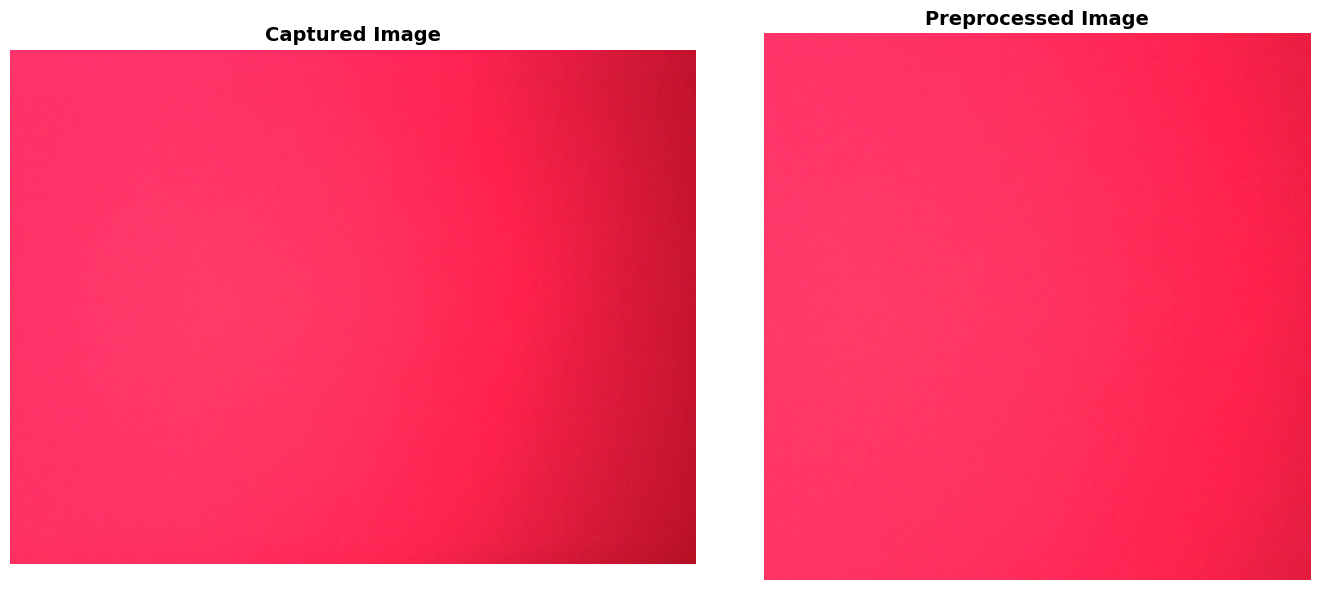


🎯 Result: Fauzan (1) (Confidence: 18.45%)

All Predictions:
  Fauzan (1)     : 18.45%

⚠️ Fauzan (1) sudah absen hari ini — tidak disimpan lagi.
✅ OpenCV webcam function ready!

💡 Uncomment the function call above to use the OpenCV window interface


In [9]:
def recognize_from_webcam_opencv():
    """Capture image from webcam using OpenCV - opens separate window"""
    if model is None:
        print("❌ Error: Model not loaded. Please run Section 2 first.")
        return
    
    print("📷 Opening webcam...")
    print("   Press SPACE to capture, ESC to cancel")
    
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("❌ Error: Could not open webcam")
        return
    
    captured = False
    frame = None
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Display frame
        cv2.imshow('Face Recognition - Press SPACE to capture, ESC to cancel', frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord(' '):  # SPACE to capture
            captured = True
            break
        elif key == 27:  # ESC to cancel
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    if captured and frame is not None:
        print("\n✅ Image captured!")
        
        try:
            # Preprocess image
            img_batch, img_display = preprocess_image_for_prediction(frame, target_size=(224, 224), face_aware=True)
            
            # Make prediction
            predicted_name, confidence, all_predictions = predict_face(model, img_batch, class_names, confidence_threshold=0.1)
            
            # Display results
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            
            # Display captured image
            axes[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Captured Image', fontsize=14, fontweight='bold')
            axes[0].axis('off')
            
            # Display preprocessed image
            axes[1].imshow(img_display)
            axes[1].set_title('Preprocessed Image', fontsize=14, fontweight='bold')
            axes[1].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Print results
            print(f"\n🎯 Result: {predicted_name} (Confidence: {confidence:.2%})")
            print("\nAll Predictions:")
            for name, prob in all_predictions[:1]:  # Show top 5
                print(f"  {name:15s}: {prob:.2%}")

                csv_path = "absensi.csv"
                now = datetime.now()
                jam_absen = now.strftime("%H:%M")
                tanggal = now.strftime("%Y-%m-%d")

                late_or_no = "Late" if now.hour > 7 or (now.hour == 7 and now.minute > 30) else "No"

                try:
                    with open(csv_path, "r", newline="", encoding="utf-8") as f:
                        reader = csv.reader(f)
                        data = list(reader)
                except FileNotFoundError:
                    data = []

                sudah_absen = any(row[0] == predicted_name and row[1].startswith(tanggal) for row in data)

                if not sudah_absen:
                     with open(csv_path, "a", newline="", encoding="utf-8") as f:
                        writer = csv.writer(f)
                        if len(data) == 0:
                            writer.writerow(["Name", "Time", "LateOrNo"])
                        writer.writerow([predicted_name, now.isoformat(), late_or_no])
                        print(f"\n📝 Data disimpan → {predicted_name}, {now}, {late_or_no}")
                else:
                    print(f"\n⚠️ {predicted_name} sudah absen hari ini — tidak disimpan lagi.")

        except Exception as e:
            print(f"❌ Error processing image: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("❌ No image captured")

# Uncomment to use OpenCV window interface:
recognize_from_webcam_opencv()

print("✅ OpenCV webcam function ready!")
print("\n💡 Uncomment the function call above to use the OpenCV window interface")



## 7. Summary

### What This Notebook Does

✅ **Loads Your Trained Model** - From local directory (not Google Drive)

✅ **Preprocesses Images** - Same preprocessing as training (face-aware cropping)

✅ **Makes Predictions** - Recognizes faces and shows confidence scores

✅ **Two Webcam Interfaces**:
   - **Interactive Widget** (Section 5): All controls in notebook, recommended
   - **OpenCV Window** (Section 6): Traditional window interface

### How to Use

**Method 1: Interactive Widget (Recommended)**
- Go to Section 5
- Click "📷 Start Webcam"
- Click "📸 Capture" to take a photo
- Results appear automatically in the notebook!

**Method 2: OpenCV Window**
- Go to Section 6
- Uncomment `recognize_from_webcam_opencv()`
- Press SPACE to capture, ESC to exit

### Tips

- **Confidence Threshold**: Default is 50%. Adjust in `predict_face()` function if needed
- **Multiple Faces**: Current implementation detects and processes the largest face
- **Preprocessing**: Uses same face-aware preprocessing as training for best results
- **Model Path**: Update `MODELS_DIR` in Section 2 to point to your model location
- **Webcam Access**: Make sure no other application is using your webcam

### Troubleshooting

**"Model not loaded" error**:
- Make sure you've run Section 2
- Check that model files exist in the `MODELS_DIR` path
- Update `MODELS_DIR` if your model is in a different location

**"Could not open webcam" error**:
- Make sure your webcam is connected
- Close other applications using the webcam (Zoom, Teams, etc.)
- Try changing the camera index: `cv2.VideoCapture(1)` instead of `cv2.VideoCapture(0)`

**"No face detected"**:
- Image will use center crop fallback
- Ensure good lighting
- Face the camera directly
- Move closer to the camera

**Low confidence scores**:
- Person might not be in training data
- Try adding more training images
- Check if face is clearly visible and well-lit

**For File Upload in Colab**:
- Use `07b_face_recognition_colab.ipynb` for file upload and Google Drive access
- This notebook is specifically for local webcam recognition

**Congratulations!** You can now use your trained face recognition model with live webcam! 🎉

